## Dev version of integrating arima in stats models with sklearn various types of grid search to optimize arima hyperparameters.

In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels as stm
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from scipy.optimize import brute

/home/dan/miniconda2/envs/basic_ml/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
from statsmodels.tsa.stattools import adfuller

In [2]:
# Get the data for this test.
df = pd.read_csv('../../data_sets/air_passengers/AirPassengers.csv')

In [3]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.rename(index=str, columns={'#Passengers': 'passengers', 'Month': 'month'}, inplace=True)

In [5]:
df.head()

,month,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
# reset index.
df.index = pd.to_datetime(df['month'])
df.drop(['month'], axis=1, inplace=True)

In [7]:
df.head()

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [9]:
# This will be our test example.  We'll need four functions.  One to resample the data if
# necessary.  Another to check for stationarity.  Then another to search the space of 
# transformations to find the best stationary time series if possible.  We'll need to be
# careful about seasonality here...and then one more to find the optimal fit parameters.
# We'll probably actually want a fifth function to invert the transformations and then test
# the fit quality....

# At the end of the day, we'll turn this all into a custom class, but first let's get the 
# functions working.

## Look for outliters

In [10]:
# A simple outlier detection function.
def remove_outliers_simple(df, standard_deviations):
    # There should only be one numerical column
    col = df.columns.values.tolist()[0]
    # calculate the z statistic
    z = pd.DataFrame((df[col] - df[col].mean()).div(df[col].std()))
    # Identify outliers based on input number of standard_deviations
    outliers = z > standard_deviations
    # filter
    df_out = df[~outliers.any(axis=1)]
    
    return df_out

## Resample function

In [12]:
def re_sample_custom(df, unit, method='linear'):
    resampled = df.resample(unit)
    interpolated = resampled.interpolate(method=method)
    
    return interpolated

## Check for stationarity

In [ ]:
def check_stationarity(df, confidence_level):
    # This function tests the stationarity of the input time series up to a specified 
    # confidence level.
    dftest = adfuller(df.iloc[:, 0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    return dfoutput

In [ ]:
def enforce_stationarity(df, confidence_level):
    # TODO: Add capacity for trend, seasonal and residual analysis.
    # This function will test stationarity and attempt to enfoce it if not.
    # Assert that the confidence interval is right.
    assert confidence_level in [0.1, 0.05, 0.01], "Invalid confidence level for Augmented Dicky-Fuller test."
    stationary = False
    while not stationary:
        # Test for stationarity
        dfoutput = check_stationarity(df, confidence_level)
        # Evaluate the results:
        p_value = dfoutput['p-value']
        test_statistic = dfoutput['Test Statistic']
        if confidence_interval = 0.1:
            critical_value = dfoutput['Critical Value (10%)']
        elif confidence_interval = 0.05:
            critical_value = dfoutput['Critical Value (5%)']
        else:
            critical_value = dfoutput['Critical Value (1%)']
        # We need to test seasonality and such here!  
    
        if p_value < confidence_level and test_statistic < critical_value:
            # We reject the null hypothesis to within the specificed confidence_level
            print('stationarity achieved.')
            print('p-value: {0}'.format(p_value))
            print('Critical value: {0}'.format(critical_value))
            print('Test statistic: {0}'.format(test_statistic))
            stationary = True
            return df
        else:
            # stationarity has can't be confidently claimed.  Try and enfore it with the usual
            # transformations.
            transformations_ = ['']

In [18]:
df.shape

(144, 1)

In [47]:
dftest = adfuller(df.iloc[:, 0].values, autolag='AIC', regression='ctt')

In [48]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

In [49]:
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

In [50]:
dfoutput

Test Statistic                  -3.233678
p-value                          0.195942
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -3.878611
Critical Value (1%)             -4.462542
Critical Value (10%)            -3.581753
dtype: float64

In [ ]:
# So we cannot reject the null hypothesis, so the time series is not stationary.
#The null hypothesis of the Dickey-Fuller test is that there is a unit root of the time 
# time series (i.e. it's not stationary).

In [51]:
decomp_lin = seasonal_decompose(df, model='additive')

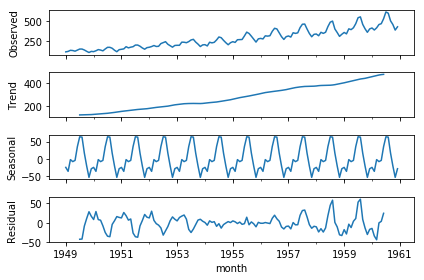

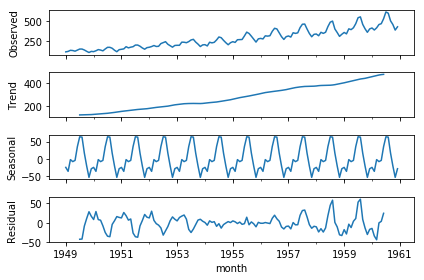

In [52]:
decomp_lin.plot()

In [ ]:
# See I want to check if the decomposed series is also stationary...

In [33]:
# This tests the level series, that is the average value of the additive time series. We 
# should test multiplicative also.
adfuller_observed = adfuller(decomp_lin.observed.iloc[:, 0].values, autolag='AIC')

In [34]:
adfuller_observed

(0.81536887920605394,
 0.99188024343764114,
 13,
 130,
 {'1%': -3.4816817173418295,
  '10%': -2.5787700591715979,
  '5%': -2.8840418343195267},
 996.69293083901903)

In [35]:
# Right so this is the same as the original result, which seems to take out the trend and such
# some how...?
adfuller_trend = adfuller(decomp_lin.trend.iloc[:, 0].values, autolag='AIC')

/home/dan/miniconda2/envs/basic_ml/lib/python2.7/site-packages/numpy/linalg/linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)


LinAlgError: SVD did not converge

In [36]:
# Hm ok...
adfuller_seasonal = adfuller(decomp_lin.seasonal.iloc[:, 0].values, autolag='AIC')

In [37]:
adfuller_seasonal

(-6049684374319733.0,
 0.0,
 13,
 130,
 {'1%': -3.4816817173418295,
  '10%': -2.5787700591715979,
  '5%': -2.8840418343195267},
 -7724.8106261738749)

In [42]:
# stationary...
adfuller_residual = adfuller(decomp_lin.resid.iloc[:, 0].values, autolag='AIC', regression='ct')

LinAlgError: SVD did not converge

## Search for a stationary series

In [ ]:
# We need a function to try out a few transformations if not stationary...we should merge this
# with the above function. 